Using device: cuda
--------------------------------------------------

Starting Mandatory Task 1: 1D Diffusion
Mean of x_T (Task 1): -0.0151, Std of x_T (Task 1): 0.9299


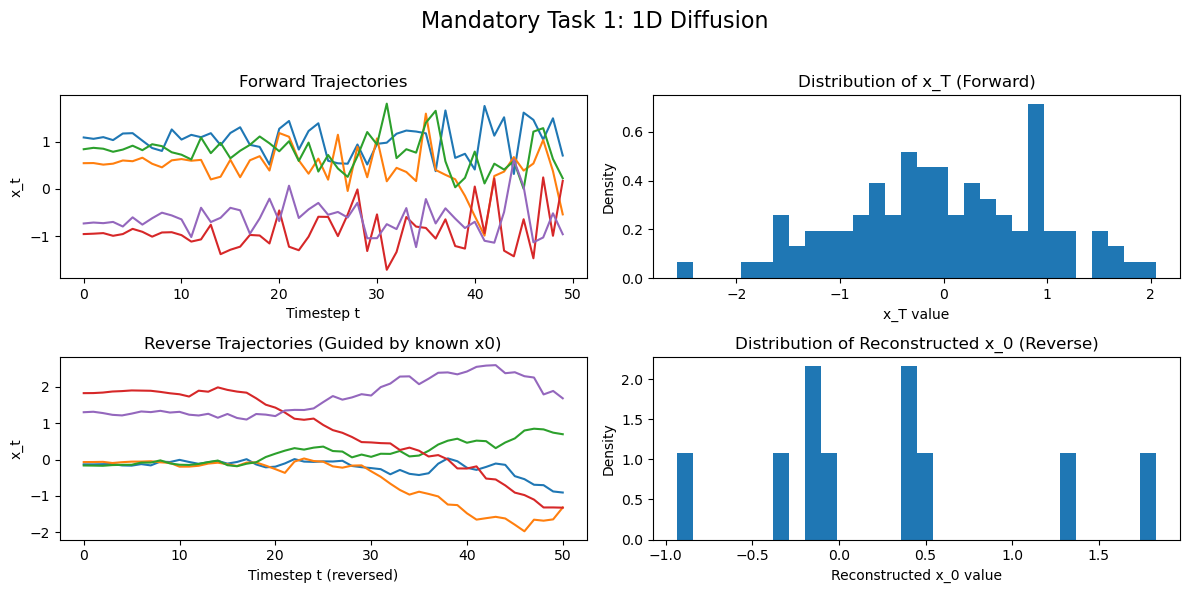

Finished Mandatory Task 1.
--------------------------------------------------


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# --- 0. Imports and Basic Setup ---

class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        device = x.device
        x = x * self.scale
        half_size = self.size // 2
        
        if self.size < 2:
            return torch.zeros(x.shape[0], self.size, device=device)

        log_val = torch.log(torch.tensor([10000.0], device=device))
        
        denominator = half_size - 1
        if denominator == 0:
            div_val = log_val 
        else:
            div_val = log_val / denominator

        arange_tensor = torch.arange(half_size, device=device).float()
        emb_base = torch.exp(-div_val * arange_tensor)

        emb = x.unsqueeze(-1) * emb_base.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        
        if emb.shape[-1] < self.size:
             padding = torch.zeros((emb.shape[0], self.size - emb.shape[-1]), device=device)
             emb = torch.cat((emb, padding), dim=-1)
        elif emb.shape[-1] > self.size:
             emb = emb[:, :self.size]
        return emb

    def __len__(self):
        return self.size

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
print("-" * 50)

# ==============================================================================
# --- 1. Mandatory Task 1: 1D Forward and Reverse Diffusion ---
# ==============================================================================
print("\nStarting Mandatory Task 1: 1D Diffusion")

m_x0_task1 = 0.0
p_x0_task1 = 1.0
T_steps_task1 = 50
betas_task1 = torch.linspace(0.0001, 0.02, T_steps_task1, device=device)
alphas_task1 = 1.0 - betas_task1
alphas_cumprod_task1 = torch.cumprod(alphas_task1, axis=0)
sqrt_alphas_cumprod_task1 = torch.sqrt(alphas_cumprod_task1)
sqrt_one_minus_alphas_cumprod_task1 = torch.sqrt(1.0 - alphas_cumprod_task1)
alphas_cumprod_prev_task1 = torch.cat((torch.tensor([1.0], device=device), alphas_cumprod_task1[:-1]))

def q_sample_task1(x_0, t_idx, noise_val=None):
    if noise_val is None:
        noise_val = torch.randn_like(x_0)
    sqrt_alpha_cumprod_t = sqrt_alphas_cumprod_task1[t_idx]
    sqrt_one_minus_alpha_cumprod_t = sqrt_one_minus_alphas_cumprod_task1[t_idx]
    x_t = sqrt_alpha_cumprod_t * x_0 + sqrt_one_minus_alpha_cumprod_t * noise_val
    return x_t

num_trajectories_task1 = 100
x0_samples_task1 = torch.normal(m_x0_task1, p_x0_task1, size=(num_trajectories_task1, 1), device=device)
forward_trajectories_task1 = torch.zeros((num_trajectories_task1, T_steps_task1, 1), device=device)
for i in range(num_trajectories_task1):
    for t_idx in range(T_steps_task1):
        forward_trajectories_task1[i, t_idx] = q_sample_task1(x0_samples_task1[i], t_idx)
x_T_samples_task1 = forward_trajectories_task1[:, -1, :]
print(f"Mean of x_T (Task 1): {x_T_samples_task1.mean().item():.4f}, Std of x_T (Task 1): {x_T_samples_task1.std().item():.4f}")

def q_posterior_mean_variance_task1(x_0, x_t, t_idx):
    beta_t = betas_task1[t_idx]
    alpha_t_cumprod = alphas_cumprod_task1[t_idx]
    alpha_t_cumprod_prev = alphas_cumprod_prev_task1[t_idx]
    alpha_t = alphas_task1[t_idx]
    posterior_mean = (torch.sqrt(alpha_t_cumprod_prev) * beta_t / (1.0 - alpha_t_cumprod)) * x_0 + \
                     (torch.sqrt(alpha_t) * (1.0 - alpha_t_cumprod_prev) / (1.0 - alpha_t_cumprod)) * x_t
    posterior_variance = (1.0 - alpha_t_cumprod_prev) / (1.0 - alpha_t_cumprod) * beta_t
    return posterior_mean, posterior_variance

num_reverse_trajectories_task1 = 10
x0_target_for_reverse_task1 = torch.normal(m_x0_task1, p_x0_task1, size=(num_reverse_trajectories_task1, 1), device=device)
x_t_current_task1 = torch.randn_like(x0_target_for_reverse_task1)
reverse_trajectories_task1 = torch.zeros((num_reverse_trajectories_task1, T_steps_task1 + 1, 1), device=device)
reverse_trajectories_task1[:, T_steps_task1, :] = x_t_current_task1
for t_loop_idx in reversed(range(T_steps_task1)):
    mean, var = q_posterior_mean_variance_task1(x0_target_for_reverse_task1, x_t_current_task1, t_loop_idx)
    noise_val = torch.randn_like(x_t_current_task1) if t_loop_idx > 0 else torch.zeros_like(x_t_current_task1)
    var = torch.clamp(var, min=1e-20)
    x_t_prev = mean + torch.sqrt(var) * noise_val
    x_t_current_task1 = x_t_prev
    reverse_trajectories_task1[:, t_loop_idx, :] = x_t_current_task1
x0_reconstructed_task1 = reverse_trajectories_task1[:, 0, :]

plt.figure(figsize=(12, 6))
plt.suptitle("Mandatory Task 1: 1D Diffusion", fontsize=16)
plt.subplot(2, 2, 1); plt.title("Forward Trajectories")
for i in range(min(5, num_trajectories_task1)): plt.plot(range(T_steps_task1), forward_trajectories_task1[i, :, 0].cpu().numpy())
plt.xlabel("Timestep t"); plt.ylabel("x_t")
plt.subplot(2, 2, 2); plt.title("Distribution of x_T (Forward)")
plt.hist(x_T_samples_task1.cpu().numpy().flatten(), bins=30, density=True); plt.xlabel("x_T value"); plt.ylabel("Density")
plt.subplot(2, 2, 3); plt.title("Reverse Trajectories (Guided by known x0)")
for i in range(min(5, num_reverse_trajectories_task1)): plt.plot(range(T_steps_task1 + 1), reverse_trajectories_task1[i, :, 0].cpu().numpy())
plt.xlabel("Timestep t (reversed)"); plt.ylabel("x_t")
plt.subplot(2, 2, 4); plt.title("Distribution of Reconstructed x_0 (Reverse)")
plt.hist(x0_reconstructed_task1.cpu().numpy().flatten(), bins=30, density=True); plt.xlabel("Reconstructed x_0 value"); plt.ylabel("Density")
plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()
print("Finished Mandatory Task 1."); print("-" * 50)


Starting Mandatory Task 2: 2D Denoising with MLP
Loaded circle_pts.npy: torch.Size([1000, 2])
Loaded dinohead_pts.npy: torch.Size([10240, 2])
Loaded square_pts.npy: torch.Size([1000, 2])

--- Training for Shape: Circle ---
Dataset shape: torch.Size([1000, 2])
Starting Task 2 training for Circle: 50000 epochs.
Shape Circle - Epoch 0/50000, Loss: 1.0725
Shape Circle - Epoch 2000/50000, Loss: 0.3645
Shape Circle - Epoch 4000/50000, Loss: 0.2542
Shape Circle - Epoch 6000/50000, Loss: 0.2624
Shape Circle - Epoch 8000/50000, Loss: 0.2976
Shape Circle - Epoch 10000/50000, Loss: 0.3004
Shape Circle - Epoch 12000/50000, Loss: 0.2837
Shape Circle - Epoch 14000/50000, Loss: 0.2968
Shape Circle - Epoch 16000/50000, Loss: 0.2587
Shape Circle - Epoch 18000/50000, Loss: 0.2365
Shape Circle - Epoch 20000/50000, Loss: 0.3272
Shape Circle - Epoch 22000/50000, Loss: 0.2901
Shape Circle - Epoch 24000/50000, Loss: 0.2798
Shape Circle - Epoch 26000/50000, Loss: 0.3047
Shape Circle - Epoch 28000/50000, Loss

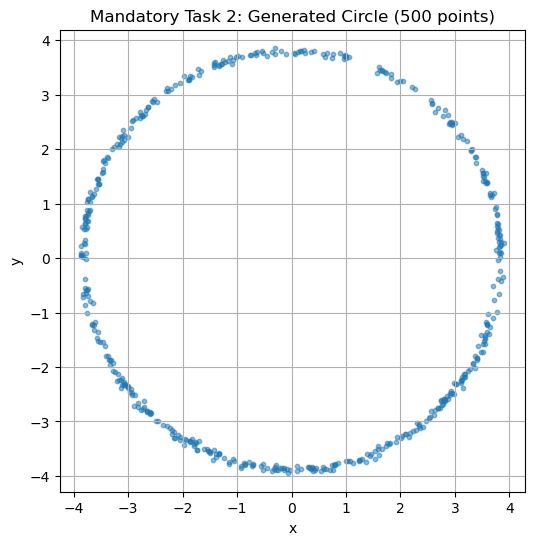


--- Training for Shape: Square ---
Dataset shape: torch.Size([1000, 2])
Starting Task 2 training for Square: 50000 epochs.
Shape Square - Epoch 0/50000, Loss: 0.8487
Shape Square - Epoch 2000/50000, Loss: 0.3042
Shape Square - Epoch 4000/50000, Loss: 0.2869
Shape Square - Epoch 6000/50000, Loss: 0.2899
Shape Square - Epoch 8000/50000, Loss: 0.3577
Shape Square - Epoch 10000/50000, Loss: 0.3247
Shape Square - Epoch 12000/50000, Loss: 0.3676
Shape Square - Epoch 14000/50000, Loss: 0.4719
Shape Square - Epoch 16000/50000, Loss: 0.2985
Shape Square - Epoch 18000/50000, Loss: 0.3222
Shape Square - Epoch 20000/50000, Loss: 0.3409
Shape Square - Epoch 22000/50000, Loss: 0.2916
Shape Square - Epoch 24000/50000, Loss: 0.3237
Shape Square - Epoch 26000/50000, Loss: 0.2808
Shape Square - Epoch 28000/50000, Loss: 0.2941
Shape Square - Epoch 30000/50000, Loss: 0.3955
Shape Square - Epoch 32000/50000, Loss: 0.2994
Shape Square - Epoch 34000/50000, Loss: 0.2654
Shape Square - Epoch 36000/50000, Loss

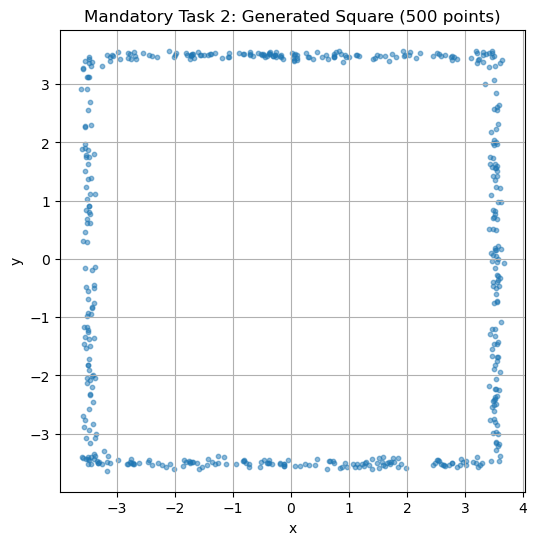


--- Training for Shape: Dinohead ---
Dataset shape: torch.Size([10240, 2])
Starting Task 2 training for Dinohead: 50000 epochs.
Shape Dinohead - Epoch 0/50000, Loss: 0.9928
Shape Dinohead - Epoch 2000/50000, Loss: 0.3299
Shape Dinohead - Epoch 4000/50000, Loss: 0.2764
Shape Dinohead - Epoch 6000/50000, Loss: 0.3629
Shape Dinohead - Epoch 8000/50000, Loss: 0.3233
Shape Dinohead - Epoch 10000/50000, Loss: 0.3494
Shape Dinohead - Epoch 12000/50000, Loss: 0.4091
Shape Dinohead - Epoch 14000/50000, Loss: 0.3024
Shape Dinohead - Epoch 16000/50000, Loss: 0.3337
Shape Dinohead - Epoch 18000/50000, Loss: 0.3204
Shape Dinohead - Epoch 20000/50000, Loss: 0.3448
Shape Dinohead - Epoch 22000/50000, Loss: 0.3680
Shape Dinohead - Epoch 24000/50000, Loss: 0.3098
Shape Dinohead - Epoch 26000/50000, Loss: 0.3057
Shape Dinohead - Epoch 28000/50000, Loss: 0.4143
Shape Dinohead - Epoch 30000/50000, Loss: 0.3723
Shape Dinohead - Epoch 32000/50000, Loss: 0.3057
Shape Dinohead - Epoch 34000/50000, Loss: 0.36

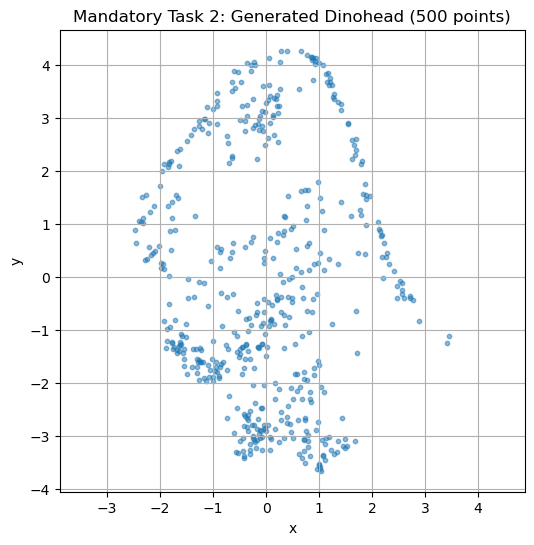


Finished All Shapes for Mandatory Task 2.
--------------------------------------------------


In [2]:
# ==============================================================================
# --- 2. Mandatory Task 2: 2D Denoising with Neural Network ---
# ==============================================================================
print("\nStarting Mandatory Task 2: 2D Denoising with MLP")

try:
    circle_data_np = np.load("circle_pts.npy")
    dinohead_data_np = np.load("dinohead_pts.npy")
    square_data_np = np.load("square_pts.npy")
    circle_data_task2 = torch.from_numpy(circle_data_np).float().to(device)
    dinohead_data_task2 = torch.from_numpy(dinohead_data_np).float().to(device)
    square_data_task2 = torch.from_numpy(square_data_np).float().to(device)
    print(f"Loaded circle_pts.npy: {circle_data_task2.shape}")
    print(f"Loaded dinohead_pts.npy: {dinohead_data_task2.shape}")
    print(f"Loaded square_pts.npy: {square_data_task2.shape}")
except FileNotFoundError as e:
    print(f"Error loading data files for Task 2: {e}. Please ensure .npy files are present.")
    exit()

datasets_to_train_task2 = [
    ("Circle", circle_data_task2),
    ("Square", square_data_task2),
    ("Dinohead", dinohead_data_task2)
]

# --- MLP for Noise Prediction (Task 2) ---
class SimplerNoisePredictionMLP(nn.Module):
    def __init__(self, point_dim=2, time_emb_dim=32, point_coord_emb_dim=32, hidden_dim=128):
        super().__init__()
        self.time_embedder = SinusoidalEmbedding(time_emb_dim)
        self.point_x_embedder = SinusoidalEmbedding(point_coord_emb_dim)
        self.point_y_embedder = SinusoidalEmbedding(point_coord_emb_dim)
        fc_input_dim = time_emb_dim + point_coord_emb_dim * 2
        self.model_mlp = nn.Sequential(
            nn.Linear(fc_input_dim, hidden_dim), nn.Mish(),
            nn.Linear(hidden_dim, hidden_dim), nn.Mish(),
            nn.Linear(hidden_dim, point_dim)
        )
    def forward(self, x_points, time_steps):
        t_emb = self.time_embedder(time_steps.float())
        x_coord_emb = self.point_x_embedder(x_points[:, 0])
        y_coord_emb = self.point_y_embedder(x_points[:, 1])
        point_embeddings = torch.cat([x_coord_emb, y_coord_emb], dim=-1)
        combined_input = torch.cat([point_embeddings, t_emb], dim=-1)
        return self.model_mlp(combined_input)

# --- Diffusion Parameters for Task 2 (common for all shapes) ---
T_diffusion_steps_task2 = 1000
betas_task2 = torch.linspace(0.0001, 0.02, T_diffusion_steps_task2, device=device)
alphas_task2 = 1.0 - betas_task2
alphas_cumprod_task2 = torch.cumprod(alphas_task2, axis=0)
sqrt_alphas_cumprod_task2 = torch.sqrt(alphas_cumprod_task2)
sqrt_one_minus_alphas_cumprod_task2 = torch.sqrt(1.0 - alphas_cumprod_task2)
alphas_cumprod_prev_task2 = torch.cat([torch.tensor([1.0], device=device), alphas_cumprod_task2[:-1]])
posterior_variance_task2 = betas_task2 * (1. - alphas_cumprod_prev_task2) / (1. - alphas_cumprod_task2)

def q_sample_task2(x_0, t_indices, noise_val=None):
    if noise_val is None: noise_val = torch.randn_like(x_0)
    sqrt_alpha_cumprod_t = sqrt_alphas_cumprod_task2[t_indices].unsqueeze(-1)
    sqrt_one_minus_alpha_cumprod_t = sqrt_one_minus_alphas_cumprod_task2[t_indices].unsqueeze(-1)
    x_t = sqrt_alpha_cumprod_t * x_0 + sqrt_one_minus_alpha_cumprod_t * noise_val
    return x_t

@torch.no_grad()
def sample_ddpm(model_to_sample, shape_to_sample, num_total_steps, device_to_sample_on, 
                alphas_param, alphas_cumprod_param, betas_param, posterior_variance_param):
    model_to_sample.eval()
    batch_size = shape_to_sample[0]
    x_t = torch.randn(shape_to_sample, device=device_to_sample_on)
    for t_val in reversed(range(num_total_steps)):
        time_tensor = torch.full((batch_size,), t_val, device=device_to_sample_on, dtype=torch.long)
        predicted_noise = model_to_sample(x_t, time_tensor)
        alpha_t = alphas_param[t_val]
        alpha_t_cumprod = alphas_cumprod_param[t_val]
        sqrt_one_minus_alpha_t_cumprod = torch.sqrt(1.0 - alpha_t_cumprod)
        eps_coeff = (1.0 - alpha_t) / sqrt_one_minus_alpha_t_cumprod
        mean = (1.0 / torch.sqrt(alpha_t)) * (x_t - eps_coeff * predicted_noise)
        if t_val == 0:
            noise_on_step_var = torch.tensor(0.0, device=device_to_sample_on)
            noise_value = torch.zeros_like(x_t)
        else:
            noise_on_step_var = posterior_variance_param[t_val]
            noise_on_step_var = torch.clamp(noise_on_step_var, min=1e-20)
            noise_value = torch.randn_like(x_t)
        x_t = mean + torch.sqrt(noise_on_step_var) * noise_value
    model_to_sample.train()
    return x_t

# --- Loop to Train Separate Models for Each Shape in Task 2 ---
num_epochs_task2 = 50000
batch_size_task2 = 128
learning_rate_task2 = 1e-3

for shape_name, current_data_task2_selected in datasets_to_train_task2:
    print(f"\n--- Training for Shape: {shape_name} ---")
    print(f"Dataset shape: {current_data_task2_selected.shape}")

    point_dim_task2 = current_data_task2_selected.shape[1]
    model_task2_current_shape = SimplerNoisePredictionMLP(
        point_dim=point_dim_task2, time_emb_dim=32, 
        point_coord_emb_dim=32, hidden_dim=128
    ).to(device)
    optimizer_task2_current_shape = optim.Adam(model_task2_current_shape.parameters(), lr=learning_rate_task2)
    loss_fn_task2 = nn.MSELoss()

    print(f"Starting Task 2 training for {shape_name}: {num_epochs_task2} epochs.")
    for epoch in range(num_epochs_task2):
        optimizer_task2_current_shape.zero_grad()
        indices = torch.randint(0, current_data_task2_selected.shape[0], (batch_size_task2,))
        x0_batch = current_data_task2_selected[indices].to(device)
        t_sampled = torch.randint(0, T_diffusion_steps_task2, (batch_size_task2,), device=device).long()
        true_noise_sampled = torch.randn_like(x0_batch)
        xt_batch = q_sample_task2(x0_batch, t_sampled, noise_val=true_noise_sampled)
        predicted_noise = model_task2_current_shape(xt_batch, t_sampled)
        loss = loss_fn_task2(predicted_noise, true_noise_sampled)
        loss.backward()
        optimizer_task2_current_shape.step()
        if epoch % 2000 == 0: # Log less frequently for multiple shapes
            print(f"Shape {shape_name} - Epoch {epoch}/{num_epochs_task2}, Loss: {loss.item():.4f}")
    print(f"Finished Task 2 training for {shape_name}.")

    num_generated_samples_task2 = 500
    generated_points_task2 = sample_ddpm(
        model_task2_current_shape,
        (num_generated_samples_task2, point_dim_task2),
        T_diffusion_steps_task2, device,
        alphas_task2, alphas_cumprod_task2, betas_task2, posterior_variance_task2
    )
    plt.figure(figsize=(6, 6))
    plt.title(f"Mandatory Task 2: Generated {shape_name} ({num_generated_samples_task2} points)")
    plt.scatter(generated_points_task2[:,0].cpu().numpy(), generated_points_task2[:,1].cpu().numpy(), alpha=0.5, s=10)
    plt.xlabel("x"); plt.ylabel("y"); plt.axis('equal'); plt.grid(True); plt.show()

print("\nFinished All Shapes for Mandatory Task 2."); print("-" * 50)


Starting Advanced Part: Conditional Generation for 'Stars' Dataset
Loaded stars_data.npy: torch.Size([1024, 1024, 2])
ConditionalMLP initialized with input dim for main MLP: 194
Starting Advanced Part training: 50000 epochs, 16 stars per meta-batch.
Advanced Epoch 0/50000, Loss: 1.0037
Advanced Epoch 1000/50000, Loss: 0.2985
Advanced Epoch 2000/50000, Loss: 0.2812
Advanced Epoch 3000/50000, Loss: 0.2697
Advanced Epoch 4000/50000, Loss: 0.2786
Advanced Epoch 5000/50000, Loss: 0.2688
Advanced Epoch 6000/50000, Loss: 0.2749
Advanced Epoch 7000/50000, Loss: 0.2730
Advanced Epoch 8000/50000, Loss: 0.2743
Advanced Epoch 9000/50000, Loss: 0.2670
Advanced Epoch 10000/50000, Loss: 0.2684
Advanced Epoch 11000/50000, Loss: 0.2669
Advanced Epoch 12000/50000, Loss: 0.2703
Advanced Epoch 13000/50000, Loss: 0.2750
Advanced Epoch 14000/50000, Loss: 0.2691
Advanced Epoch 15000/50000, Loss: 0.2698
Advanced Epoch 16000/50000, Loss: 0.2760
Advanced Epoch 17000/50000, Loss: 0.2715
Advanced Epoch 18000/500

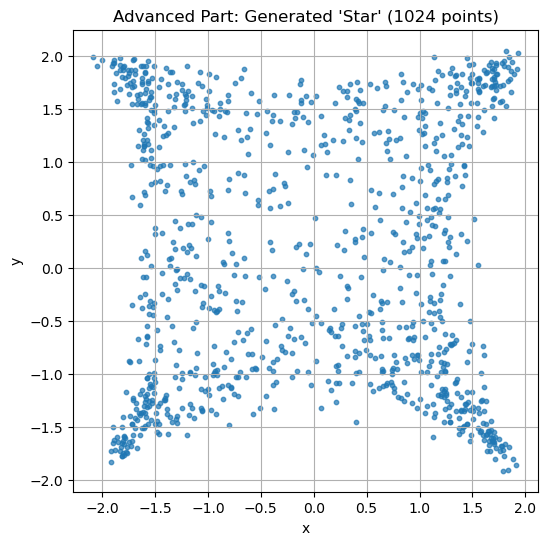

Full Project IV script finished.
--------------------------------------------------


In [3]:
# ==============================================================================
# --- 3. Advanced Part: Conditional Generation for "Stars" Dataset ---
# ==============================================================================
print("\nStarting Advanced Part: Conditional Generation for 'Stars' Dataset")
try:
    stars_data_np = np.load("stars_data.npy")
    stars_data_adv = torch.from_numpy(stars_data_np).float().to(device)
    print(f"Loaded stars_data.npy: {stars_data_adv.shape}")
    if len(stars_data_adv.shape) != 3 or stars_data_adv.shape[2] != 2:
        print("Error: stars_data.npy does not have shape [num_stars, num_points_per_star, 2]."); exit()
except FileNotFoundError: print("Error: stars_data.npy not found."); exit()
except Exception as e: print(f"Error loading stars_data.npy: {e}"); exit()

class ConditionalNoisePredictionMLP(nn.Module):
    def __init__(self, point_dim=2, time_emb_dim=64, point_coord_emb_dim=64,
                 global_feature_dim=2, hidden_dim=256):
        super().__init__()
        self.time_embedder = SinusoidalEmbedding(time_emb_dim)
        self.point_x_embedder = SinusoidalEmbedding(point_coord_emb_dim)
        self.point_y_embedder = SinusoidalEmbedding(point_coord_emb_dim)
        fc_input_dim = time_emb_dim + (point_coord_emb_dim * 2) + global_feature_dim
        self.model_mlp = nn.Sequential(
            nn.Linear(fc_input_dim, hidden_dim), nn.Mish(),
            nn.Linear(hidden_dim, hidden_dim), nn.Mish(),
            nn.Linear(hidden_dim, hidden_dim), nn.Mish(),
            nn.Linear(hidden_dim, point_dim)
        )
        print(f"ConditionalMLP initialized with input dim for main MLP: {fc_input_dim}")
    def forward(self, x_points, time_steps, global_batch_feature):
        t_emb = self.time_embedder(time_steps.float())
        point_x_emb = self.point_x_embedder(x_points[:, 0])
        point_y_emb = self.point_y_embedder(x_points[:, 1])
        point_embeddings = torch.cat([point_x_emb, point_y_emb], dim=-1)
        combined_input = torch.cat([point_embeddings, t_emb, global_batch_feature], dim=-1)
        return self.model_mlp(combined_input)

T_diffusion_steps_advanced = 1000
betas_advanced = betas_task2 
alphas_advanced = alphas_task2
alphas_cumprod_advanced = alphas_cumprod_task2
sqrt_alphas_cumprod_advanced = sqrt_alphas_cumprod_task2
sqrt_one_minus_alphas_cumprod_advanced = sqrt_one_minus_alphas_cumprod_task2
posterior_variance_advanced = posterior_variance_task2

def q_sample_adv_wrapper(x_0_points, t_indices_points, noise_points=None):
    if noise_points is None: noise_points = torch.randn_like(x_0_points)
    batch_sqrt_alphas_cumprod = sqrt_alphas_cumprod_advanced[t_indices_points].unsqueeze(-1)
    batch_sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod_advanced[t_indices_points].unsqueeze(-1)
    xt_points = batch_sqrt_alphas_cumprod * x_0_points + batch_sqrt_one_minus_alphas_cumprod * noise_points
    return xt_points

adv_point_dim = stars_data_adv.shape[2]
adv_global_feature_dim = adv_point_dim
model_advanced = ConditionalNoisePredictionMLP(
    point_dim=adv_point_dim, time_emb_dim=64, point_coord_emb_dim=64,
    global_feature_dim=adv_point_dim, hidden_dim=256
).to(device)
optimizer_advanced = optim.Adam(model_advanced.parameters(), lr=1e-4)
loss_fn_advanced = nn.MSELoss()

num_epochs_advanced = 50000 
batch_size_of_stars = 16 
num_total_stars = stars_data_adv.shape[0]
num_points_per_star = stars_data_adv.shape[1]
print(f"Starting Advanced Part training: {num_epochs_advanced} epochs, {batch_size_of_stars} stars per meta-batch.")
for epoch in range(num_epochs_advanced):
    optimizer_advanced.zero_grad()
    star_indices = torch.randint(0, num_total_stars, (batch_size_of_stars,))
    x0_stars_batch = stars_data_adv[star_indices].to(device)
    x0_points_flat = x0_stars_batch.reshape(-1, adv_point_dim)
    t_points_flat = torch.randint(0, T_diffusion_steps_advanced, (x0_points_flat.shape[0],), device=device).long()
    true_noise_flat = torch.randn_like(x0_points_flat)
    xt_points_flat = q_sample_adv_wrapper(x0_points_flat, t_points_flat, noise_points=true_noise_flat)
    xt_stars_view = xt_points_flat.reshape(batch_size_of_stars, num_points_per_star, adv_point_dim)
    global_feat_per_star = torch.mean(xt_stars_view, dim=1, keepdim=True)
    global_feat_tiled = global_feat_per_star.repeat(1, num_points_per_star, 1)
    global_feat_flat = global_feat_tiled.reshape(-1, adv_global_feature_dim)
    predicted_noise_flat = model_advanced(xt_points_flat, t_points_flat, global_feat_flat)
    loss = loss_fn_advanced(predicted_noise_flat, true_noise_flat)
    loss.backward(); optimizer_advanced.step()
    if epoch % 1000 == 0: print(f"Advanced Epoch {epoch}/{num_epochs_advanced}, Loss: {loss.item():.4f}")
print("Finished training for Advanced Part.")

@torch.no_grad()
def sample_ddpm_advanced(model_to_sample, num_points_in_gen_sample, num_total_steps, device_to_sample_on,
                         alphas_param_adv, sqrt_one_minus_alphas_cumprod_param_adv, 
                         posterior_variance_param_adv, point_dim_adv_param):
    model_to_sample.eval()
    shape_to_sample = (num_points_in_gen_sample, point_dim_adv_param)
    x_t = torch.randn(shape_to_sample, device=device_to_sample_on)
    for t_val in reversed(range(num_total_steps)):
        time_tensor = torch.full((num_points_in_gen_sample,), t_val, device=device_to_sample_on, dtype=torch.long)
        current_global_feature = torch.mean(x_t, dim=0, keepdim=True).repeat(num_points_in_gen_sample, 1)
        predicted_noise = model_to_sample(x_t, time_tensor, current_global_feature)
        alpha_t = alphas_param_adv[t_val]
        sqrt_one_minus_alpha_t_cumprod = sqrt_one_minus_alphas_cumprod_param_adv[t_val]
        eps_coeff = (1 - alpha_t) / sqrt_one_minus_alpha_t_cumprod
        mean = (1 / torch.sqrt(alpha_t)) * (x_t - eps_coeff * predicted_noise)
        if t_val == 0:
            noise_on_step_var = torch.tensor(0.0, device=device_to_sample_on)
            noise_value = torch.zeros_like(x_t)
        else:
            noise_on_step_var = posterior_variance_param_adv[t_val]
            noise_on_step_var = torch.clamp(noise_on_step_var, min=1e-20)
            noise_value = torch.randn_like(x_t)
        x_t = mean + noise_on_step_var.sqrt() * noise_value
    model_to_sample.train()
    return x_t

print("Generating samples for Advanced Part...")
num_points_per_star_sample_adv = stars_data_adv.shape[1]
generated_stars_points_adv = sample_ddpm_advanced(
    model_advanced, num_points_per_star_sample_adv, T_diffusion_steps_advanced, device,
    alphas_advanced, sqrt_one_minus_alphas_cumprod_advanced,
    posterior_variance_advanced, adv_point_dim
)
plt.figure(figsize=(6,6)); plt.title(f"Advanced Part: Generated 'Star' ({num_points_per_star_sample_adv} points)")
plt.scatter(generated_stars_points_adv[:, 0].cpu().numpy(), generated_stars_points_adv[:, 1].cpu().numpy(), alpha=0.7, s=10)
plt.xlabel("x"); plt.ylabel("y"); plt.axis('equal'); plt.grid(True); plt.show()
print("Full Project IV script finished."); print("-" * 50)